### Importing Libraries

In [11]:
from collections import OrderedDict
from io import StringIO
import pandas as pd
import numpy as np
import prince
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import rpy2

### Functions Used:

In [12]:
def gct_format_to_df(file_path):
    """This function is used to read the gct file and convert it into dataframe"""
    raw_intensity_df = pd.DataFrame()
    metadata_df = pd.DataFrame()
    dimensions_dict = {}
    read_gct = open(file_path,'r').read().splitlines()
    gct_format_info = list(map(lambda element: element.split('\t'), read_gct[:2])) # separate strings based on '\t'
    gct_format_info = list(map(lambda element: list(filter(None,element)),gct_format_info))
    raw_intensity_data = '\n'.join(read_gct[2:])
    version = gct_format_info[0][0] # Version
    if str(version) != '#1.3':
        return 'This function only supports version #1.3. please check the gct format'
    dimensions = gct_format_info[1] # Dimensions
    dimensions = list(map(lambda x:int(float(x)), dimensions)) # convert string to int        
    dimensions_dict = {'rids':dimensions[0],'cids':dimensions[1],'rhds':dimensions[2],'chds':dimensions[3]}
    # Read Raw intensity data
    TESTDATA = StringIO(raw_intensity_data)
    gct_df = pd.read_csv(TESTDATA,sep='\t')
    raw_intensity_df = gct_df.iloc[dimensions_dict['chds']:].reset_index(drop=True)
    # Read metadata
    metadata_df = gct_df.iloc[:dimensions_dict['chds']].T
    metadata_df.columns = metadata_df.iloc[0]
    metadata_df = metadata_df.iloc[(dimensions_dict['rhds']+1):]
    metadata_df = metadata_df.reset_index()
    metadata_df = metadata_df.rename(columns={'index':'SampleName'})
    return [raw_intensity_df, metadata_df]

def df_to_gct_format(raw_intensity_df,meta_sample_df,save_path):
    """This function is used to convert raw intensity dataframe to gct format using metadata information"""
    raw_intensity_df_cp = raw_intensity_df.copy()
    meta_sample_df_cp = meta_sample_df.copy()
    raw_samples_list =  raw_intensity_df_cp.columns.tolist()
    metadata_samples_list = meta_sample_df_cp[meta_sample_df_cp.columns[0]].tolist()
    samples_list = sorted(set(metadata_samples_list) & set(raw_samples_list), key = raw_samples_list.index)
    rhds_list = raw_intensity_df_cp.drop(samples_list,axis=1).columns.tolist()
    metab_counts = len(raw_intensity_df_cp[rhds_list[0]])
    meta_sample_df_cp.set_index(meta_sample_df_cp.columns[0],inplace=True)
    metadata_cols_list = meta_sample_df_cp.columns
    metadata_cols_len = len(metadata_cols_list)
    for chds_index in range(metadata_cols_len):
        metadata_col = metadata_cols_list[chds_index]
        chds_sample_map_list = meta_sample_df_cp.loc[samples_list][metadata_col].values.tolist()
        chds_row_list = [metadata_col] + ['na']*(len(rhds_list)-1)
        chds_row_list.extend(chds_sample_map_list)
        raw_intensity_df_cp.loc[(chds_index-metadata_cols_len)] = chds_row_list
    raw_intensity_df_cp.index = raw_intensity_df_cp.index + metadata_cols_len
    raw_intensity_df_cp = raw_intensity_df_cp.sort_index()
    raw_intensity_str = StringIO()
    raw_intensity_df_cp.to_csv(raw_intensity_str,sep='\t',index=False)
    dimensions = '\t'.join([str(metab_counts),str(len(samples_list)),str(len(rhds_list)-1),str(metadata_cols_len)])
    version = '#1.3'
    gct_format_str = '\n'.join([version,dimensions,raw_intensity_str.getvalue()])
    with open(save_path, "w") as text_file:
        text_file.write(gct_format_str)
        
def make_unique_id_raw_df(maven_output, mode):
    """This function will make unique ids for the metabolites using the medRt, medMz and mode information."""
    maven_output_updated = maven_output.copy()
    isotopelabel_list = maven_output_updated['isotopeLabel'].tolist()
    unique_id_list = []
    if 'C12 PARENT' in isotopelabel_list:
        for index, row in maven_output_updated.iterrows():
            cmpd_id = row['compoundId']
            isotopelabel = row['isotopeLabel']
            if isotopelabel == 'C12 PARENT':
                metaGroupId = row['metaGroupId']
                medRT = round(row['medRt'],3)
                medMZ = round(row['medMz'],3)
            unique_id = '_'.join([str(metaGroupId),str(cmpd_id),str(medMZ),str(medRT),str(mode)])
            unique_id_list.append(unique_id)
    else:
        for index, row in maven_output_updated.iterrows():
            metaGroupId = row['metaGroupId']
            cmpd_id = row['compoundId']
            medRT = round(row['medRt'],3)
            medMZ = round(row['medMz'],3)
            unique_id = '_'.join([str(metaGroupId),str(cmpd_id),str(medMZ),str(medRT),mode])
            unique_id_list.append(unique_id)

    maven_output_updated['uniqueId'] = unique_id_list
    return maven_output_updated

def filter_samples_cols_df(raw_intensity_df):
    """This function can be used to filter columns."""
    remove_cols_list = ['label', 'metaGroupId', 'groupId', 'goodPeakCount', 
                        'maxQuality', 'formula', 'expectedRtDiff','ppmDiff', 'parent']
    raw_intensity_filtered_cols_df = raw_intensity_df.drop(remove_cols_list,axis=1)
    return raw_intensity_filtered_cols_df

def calculate_pooltotal_df(raw_intensity_unique_id_df):
    """This function can be used to calculate pooltotals."""
    cmpd_identifiers_list = ['uniqueId','compound', 'compoundId', 'medMz', 'medRt', 'isotopeLabel']
    if cmpd_identifiers_list[0] not in raw_intensity_unique_id_df.columns:
        return "Please do the preprocessing of the maven output"
    compound_samples_raw_intensity_df = filter_samples_cols_df(raw_intensity_unique_id_df)
    raw_intensity_filtered_df = compound_samples_raw_intensity_df.drop(cmpd_identifiers_list[3:],axis=1)
    pooltotal_df = raw_intensity_filtered_df.groupby(cmpd_identifiers_list[:3],sort=False).sum(numeric_only=True).reset_index()
    pooltotal_df_object= pooltotal_df[cmpd_identifiers_list[0]].str.split('_').str
    pooltotal_df[cmpd_identifiers_list[3]] = pooltotal_df_object[2]
    pooltotal_df[cmpd_identifiers_list[4]] = pooltotal_df_object[3]
    samples_list = pooltotal_df.drop(cmpd_identifiers_list[:5], axis=1).columns.tolist()
    columns_order_list = cmpd_identifiers_list[:5] + samples_list
    pooltotal_df = pooltotal_df.reindex(columns=columns_order_list)
    return pooltotal_df

def create_cohortwise_compound_df(processed_df, metadata_sample_df, cohort_col='Cohort'):
    """This function will make new dataframe having information of mean and std for each cohort"""
    cohort_compound_df = pd.DataFrame()
    cohort_list = metadata_sample_df[cohort_col].unique().tolist()
    samples_list = metadata_sample_df[metadata_sample_df.columns[0]].tolist()
    id_cols_list = processed_df.columns[~processed_df.columns.isin(samples_list)].tolist()
    all_cols_list = id_cols_list + ['cohort', 'cv', 'mean', 'std']
    for index, row in processed_df.iterrows():
        id_cols_values = row[id_cols_list]
        for cohort in cohort_list:
            cv = np.nan
            cohort_samples = metadata_sample_df[metadata_sample_df[cohort_col]==cohort][metadata_sample_df.columns[0]]
            cohort_samples_values = row[cohort_samples].astype(float)
            mean = np.mean(cohort_samples_values.values)
            std = np.std(cohort_samples_values.values)
            if mean>0:
                cv = (std/mean)*100
            all_values = id_cols_values.tolist() + [cohort, cv, mean, std]
            interm_cols_dict = OrderedDict(zip(all_cols_list, all_values))
            interm_df = pd.DataFrame(interm_cols_dict, index=[0])
            cohort_compound_df = pd.concat([cohort_compound_df,interm_df],ignore_index=True)
    return cohort_compound_df

def create_cohortwise_boxplot(processed_df):
    variance_list = ['cv', 'mean', 'std']
    cohort_list = processed_df['cohort'].unique().tolist()
    data = []
    for cohort in cohort_list:
        cohortwise_metab_df = processed_df[processed_df['cohort'] == cohort]
        trace1 = go.Box(
            y = cohortwise_metab_df['cv'],
            text = cohortwise_metab_df[cohortwise_metab_df.columns[0]],
            name=cohort, boxpoints = 'all', jitter=0.3, pointpos=-1.8, boxmean='sd',
        )
        data.append(trace1)
    layout = go.Layout(title='CV Distribution across Cohorts',    
                       xaxis=dict(title='Cohorts', titlefont=dict(size=14)),
                       yaxis=dict(title='Coefficient of Variation (%)',
                                  titlefont=dict(size=14), range = [0,100])
                      )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename='box_plot')

def combine_cmpd_id_mode_df(maven_output):
    """This function will combine mode, unique-id to compound. The output will be the input of IsoCorrect."""
    combine_cmpd_id_mode_nacorr_df = maven_output.copy()
    def join_str(row):
        compound = row['compound'].split('|')[0].strip()
        unique_id = row['uniqueId']
        return "_".join([compound,unique_id])
    combine_cmpd_id_mode_nacorr_df['compound'] = combine_cmpd_id_mode_nacorr_df.apply(lambda row: join_str(row), axis=1)
    combine_cmpd_id_mode_nacorr_df.drop(['uniqueId'],axis=1,inplace=True)
    return combine_cmpd_id_mode_nacorr_df

def make_cmpd_samples_wide_format_df(na_corrected_df):
    """This function can be used to convert long format to wide format with specific columns."""
    cmpd_identifiers_list = ['uniqueId','compound', 'compoundId', 'medMz', 'medRt', 'isotopeLabel']
    pivot_na_corr_df = pd.DataFrame(pd.pivot_table(na_corrected_df, 
                                                   values='Fractional Enrichment with zero', 
                                                   index=['Name','Label'], columns='Sample', aggfunc=np.mean).reset_index())
    pivot_na_corr_df['compound'], pivot_na_corr_df['uniqueId'] = pivot_na_corr_df['Name'].str.split('_',1).str
    cmpd_id_df_object= pivot_na_corr_df['uniqueId'].str.split('_').str
    pivot_na_corr_df['compoundId'] = cmpd_id_df_object[0]
    pivot_na_corr_df['medMz'] = cmpd_id_df_object[1]
    pivot_na_corr_df['medRt'] = cmpd_id_df_object[2]
    pivot_na_corr_df.rename(columns = {'Label':'isotopeLabel'},inplace=True)
    pivot_na_corr_df.drop(['Name'],axis=1,inplace=True)
    samples_list = pivot_na_corr_df.drop(cmpd_identifiers_list, axis=1).columns.tolist()
    columns_order = cmpd_identifiers_list + samples_list
    pivot_na_corr_df = pivot_na_corr_df.reindex(columns=columns_order)
    return pivot_na_corr_df

def calculate_total_labels_df(na_corr_raw_df):
    """This function can be used to calculate total labels."""
    cmpd_identifiers_list = ['uniqueId','compound', 'compoundId', 'medMz', 'medRt', 'isotopeLabel']
    na_corr_wide_df = make_cmpd_samples_wide_format_df(na_corr_raw_df)
    filter_labels_na_corr_df = na_corr_wide_df[~(na_corr_wide_df[cmpd_identifiers_list[5]] == 'C12 PARENT')]
    total_labels_df = filter_labels_na_corr_df.groupby(cmpd_identifiers_list[:3],sort=False).sum(numeric_only=True).reset_index()
    total_labels_df_object= total_labels_df[cmpd_identifiers_list[0]].str.split('_').str
    total_labels_df[cmpd_identifiers_list[3]] = total_labels_df_object[2]
    total_labels_df[cmpd_identifiers_list[4]] = total_labels_df_object[3]
    samples_list = total_labels_df.drop(cmpd_identifiers_list[:5], axis=1).columns.tolist()
    columns_order_list = cmpd_identifiers_list[:5] + samples_list
    total_labels_df = total_labels_df.reindex(columns=columns_order_list)
    mean_metab_series = total_labels_df.drop(cmpd_identifiers_list[:5],axis=1).mean(axis=1,numeric_only=True)
    filter_bool = mean_metab_series >= 0.01
    total_labels_df = total_labels_df[filter_bool]
    return total_labels_df

def filter_unique_cmpd_combiT(diff_exp_df):
    """This function can be used to remove duplicate metabolites by pval."""
    filtered_stat_anal_df = pd.DataFrame()
    compounds = diff_exp_df['compoundId'].unique()
    for cmpd in compounds:
        short_cmpd_df = diff_exp_df[diff_exp_df['compoundId']==cmpd]
        low_pval_df =short_cmpd_df[short_cmpd_df['P.Value'] == short_cmpd_df['P.Value'].min()]
        filtered_stat_anal_df = pd.concat([filtered_stat_anal_df,low_pval_df],ignore_index=True)
    filtered_stat_anal_df = filtered_stat_anal_df[['id', 'compoundId','logFC','P.Value']]
    filtered_stat_anal_df = filtered_stat_anal_df[filtered_stat_anal_df['P.Value'] != 'NaN']
    filtered_stat_anal_df = filtered_stat_anal_df.rename(columns={"compoundId":'ID', 'id':'uniqueId'})
    filtered_stat_anal_df = filtered_stat_anal_df.set_index('uniqueId')
    return filtered_stat_anal_df

### Reading Input

In [13]:
mode = 'neg'
maven_output_path = "mavenOutput.csv"
maven_output_df = pd.read_csv(maven_output_path)

metadata_path = "LCMS_labeled_metadata.csv"
metadata_df = pd.read_csv(metadata_path)

In [14]:
updated_maven_data_uniqueId_df = make_unique_id_raw_df(maven_output_df, mode)

In [15]:
updated_maven_data_uniqueId_df.head()

label  metaGroupId  groupId  goodPeakCount       medMz   medRt  maxQuality  \
0    NaN            1        1             14  354.146667   7.426    0.846631   
1    NaN            1        2              7  355.150055   7.436    0.787734   
2    NaN            2        3             10  354.146423  10.820    0.841593   
3    NaN            2        4              3  355.149902  10.809    0.306717   
4    NaN            2        5              4  366.187622  10.836    0.638434   

   isotopeLabel                  compound compoundId  ...  091215_5M  \
0    C12 PARENT  S-Adenosylmethioninamine     C01137  ...   40790.14   
1   C13-label-1  S-Adenosylmethioninamine     C01137  ...    5971.63   
2    C12 PARENT  S-Adenosylmethioninamine     C01137  ...   20384.36   
3   C13-label-1  S-Adenosylmethioninamine     C01137  ...    5112.00   
4  C13-label-12  S-Adenosylmethioninamine     C01137  ...  114001.15   

   091215_15i  091215_15M  091215_45i  091215_45M  091215_120i  091215_120M  \
0    20586.60    29097.69    16575.75    33157.68     23444.92     37089.86   
1     3602.15     4685.95      922.59     5239.33      2699.97      7142.80   
2    10705.93    30139.17     9744.86    10462.06      6105.89     33090.57   
3     2329.22     2241.12      655.16     2966.69      1302.21      3649.03   
4        0.00    37245.90        0.00   281682.88     88549.86    179765.80   

   091215_240i  091215_240M                    uniqueId  
0     19746.51     38220.42  1_C01137_354.147_7.426_neg  
1      1565.15      5437.14  1_C01137_354.147_7.426_neg  
2     10627.45     33117.06  2_C01137_354.146_10.82_neg  
3      1428.37      5474.79  2_C01137_354.146_10.82_neg  
4         0.00    234860.62  2_C01137_354.146_10.82_neg  

[5 rows x 31 columns]

### Calculating Pool Totals

In [16]:
pooltotal_df = calculate_pooltotal_df(updated_maven_data_uniqueId_df)

In [17]:
save_pooltotal_path = 'labeled_LCMS_pooltotals.gct'
df_to_gct_format(pooltotal_df, metadata_df,save_pooltotal_path)

### NA Correction

In [18]:
na_corrected_input_df = combine_cmpd_id_mode_df(updated_maven_data_uniqueId_df)

In [19]:
na_corrected_input_df.head()

label  metaGroupId  groupId  goodPeakCount       medMz   medRt  maxQuality  \
0    NaN            1        1             14  354.146667   7.426    0.846631   
1    NaN            1        2              7  355.150055   7.436    0.787734   
2    NaN            2        3             10  354.146423  10.820    0.841593   
3    NaN            2        4              3  355.149902  10.809    0.306717   
4    NaN            2        5              4  366.187622  10.836    0.638434   

   isotopeLabel                                           compound compoundId  \
0    C12 PARENT  S-Adenosylmethioninamine_1_C01137_354.147_7.42...     C01137   
1   C13-label-1  S-Adenosylmethioninamine_1_C01137_354.147_7.42...     C01137   
2    C12 PARENT  S-Adenosylmethioninamine_2_C01137_354.146_10.8...     C01137   
3   C13-label-1  S-Adenosylmethioninamine_2_C01137_354.146_10.8...     C01137   
4  C13-label-12  S-Adenosylmethioninamine_2_C01137_354.146_10.8...     C01137   

   ...  091215_5i  091215_5M  091215_15i  091215_15M  091215_45i  091215_45M  \
0  ...   22571.85   40790.14    20586.60    29097.69    16575.75    33157.68   
1  ...    3307.93    5971.63     3602.15     4685.95      922.59     5239.33   
2  ...   20103.67   20384.36    10705.93    30139.17     9744.86    10462.06   
3  ...    1009.85    5112.00     2329.22     2241.12      655.16     2966.69   
4  ...  405690.69  114001.15        0.00    37245.90        0.00   281682.88   

   091215_120i  091215_120M  091215_240i  091215_240M  
0     23444.92     37089.86     19746.51     38220.42  
1      2699.97      7142.80      1565.15      5437.14  
2      6105.89     33090.57     10627.45     33117.06  
3      1302.21      3649.03      1428.37      5474.79  
4     88549.86    179765.80         0.00    234860.62  

[5 rows x 30 columns]

In [20]:
save_na_corr_input_file_path = "Labeled_LCMS_group_summary_na_corr_input.csv"
na_corrected_input_df.to_csv(save_na_corr_input_file_path, index=False)

### IsoCorrect on Polly

In [21]:
na_corr_file_path = 'Labeled_LCMS_group_summary_na_corr_input_merged_data.csv'
na_corr_df = pd.read_csv(na_corr_file_path)
total_labels_df = calculate_total_labels_df(na_corr_df)
total_labels_df.head()

Sample                      uniqueId  \
0       80_C21310_521.984_15.294_neg   
1       65_C04717_311.224_18.402_neg   
2        66_C04717_311.224_18.85_neg   
6        194_C01205_102.056_4.25_neg   
12      237_C03912_112.04_13.034_neg   

Sample                                           compound compoundId    medMz  \
0       (8S)-3',8-Cyclo-7,8-dihydroguanosine 5'-tripho...         80  521.984   
1       (9Z,11E)-(13S)-13-Hydroperoxyoctadeca-9,11-die...         65  311.224   
2       (9Z,11E)-(13S)-13-Hydroperoxyoctadeca-9,11-die...         66  311.224   
6                          (R)-3-Amino-2-methylpropanoate        194  102.056   
12                          (S)-1-Pyrroline-5-carboxylate        237   112.04   

Sample   medRt  091215_0M  091215_0i  091215_120M  091215_120i  091215_15M  \
0       15.294     0.0042     0.0091       0.2205       0.1189      0.0054   
1       18.402     0.0050     0.1332       0.0195       0.0027      0.0010   
2        18.85     0.0141     0.1260       0.0897       0.0007      0.1167   
6         4.25     0.0000     0.0000       0.0101       0.3373      0.0028   
12      13.034     0.0013     0.0003       0.4336       0.0624      0.0013   

Sample  ...  091215_1M  091215_1i  091215_240M  091215_240i  091215_3M  \
0       ...     0.0002     0.0030       0.1041       0.2991     0.0045   
1       ...     0.0195     0.0195       0.0588       0.0306     0.0304   
2       ...     0.0068     0.1110       0.0001       0.0001     0.0018   
6       ...     0.0000     0.0000       0.0280       0.3937     0.0058   
12      ...     0.0013     0.0006       0.0013       0.1487     0.0013   

Sample  091215_3i  091215_45M  091215_45i  091215_5M  091215_5i  
0          0.0068      0.0227      0.0625     0.0002     0.0012  
1          0.1092      0.0254      0.0379     0.0235     0.1185  
2          0.0345      0.0369      0.0526     0.0284     0.0332  
6          0.0000      0.0066      0.1205     0.0000     0.0000  
12         0.0002      0.0013      0.0073     0.0013     0.0003  

[5 rows x 21 columns]

In [22]:
save_total_labels_path = "labeled_LCMS_total_labels.gct"
df_to_gct_format(total_labels_df, metadata_df,save_total_labels_path)

In [23]:
cohortwise_compound_df = create_cohortwise_compound_df(pooltotal_df, metadata_df, cohort_col='Cohort')
create_cohortwise_boxplot(cohortwise_compound_df)

### PCA

In [24]:
data_df = pooltotal_df.copy()
drop_cols = ['compound', 'compoundId', 'medMz', 'medRt']
df = data_df.drop(drop_cols,axis=1)
df = df.set_index('uniqueId').T.reset_index().rename(columns={'index':'SampleName'})
df = pd.merge(df,metadata_df,on='SampleName',how='inner')
features = df.drop(metadata_df.columns.tolist(),axis=1).columns.tolist()
len(features)

430

In [25]:
cohorts_list = df['Cohort'].unique().tolist()
print (cohorts_list)

['Viral', 'Mock']


In [26]:
cohorts = cohorts_list
df = df[df['Cohort'].isin(cohorts)]
df = df.reset_index(drop=True)
df.head()

SampleName  1_C01137_354.147_7.426_neg  2_C01137_354.146_10.82_neg  \
0  091215_0i                        0.00                        0.00   
1  091215_0M                        0.00                        0.00   
2  091215_1i                    21614.00                    71773.40   
3  091215_1M                    28889.33                   170036.73   
4  091215_3i                    23017.16                     7424.84   

   3_C14814_353.234_17.785_neg  4_C14782_353.234_17.785_neg  \
0                     38054.23                     38054.23   
1                     38324.68                     38324.68   
2                     21852.45                     21852.45   
3                     36108.41                     36108.41   
4                     16324.05                     16324.05   

   5_C00639_353.234_17.785_neg  6_C01268_353.049_16.235_neg  \
0                     38054.23                  22131374.51   
1                     38324.68                  18322281.65   
2                     21852.45                  24461950.87   
3                     36108.41                  13218337.95   
4                     16324.05                  24437529.08   

   7_C01268_353.05_16.879_neg  8_C01304_352.065_10.002_neg  \
0                    91789.05                         0.00   
1                   117301.12                      4288.75   
2                   466154.70                     12549.11   
3                   893782.69                         0.00   
4                   476911.36                         0.00   

   9_C01304_352.065_15.787_neg  ...  422_C00984_179.056_3.941_neg  \
0                     20716.96  ...                      92203.59   
1                     37960.61  ...                     124119.03   
2                       829.13  ...                     120402.26   
3                      2753.04  ...                     137925.75   
4                       615.19  ...                       8912.18   

   423_C00221_179.056_3.127_neg  424_C00221_179.056_3.941_neg  \
0                     441276.63                      92203.59   
1                     839479.91                     124119.03   
2                     325453.08                     120402.26   
3                    1619018.89                     137925.75   
4                     527782.60                       8912.18   

   425_C00031_179.056_3.127_neg  426_C00031_179.056_3.941_neg  \
0                     441276.63                      92203.59   
1                     839479.91                     124119.03   
2                     325453.08                     120402.26   
3                    1619018.89                     137925.75   
4                     527782.60                       8912.18   

   427_C01092_186.114_14.859_neg  428_C00631_184.986_13.567_neg  \
0                      105351.48                       71838.46   
1                      117416.57                       43626.08   
2                      125336.54                       56024.83   
3                       84903.45                       38274.60   
4                      122801.70                      100712.60   

   429_C00197_184.986_13.567_neg  430_C01005_184.002_8.139_neg  Cohort  
0                       71838.46                      56787.87   Viral  
1                       43626.08                      24064.57    Mock  
2                       56024.83                      87430.85   Viral  
3                       38274.60                     143364.36    Mock  
4                      100712.60                      81344.91   Viral  

[5 rows x 432 columns]

In [27]:
x1 = df.loc[:, features].astype(float)
x1.head()

1_C01137_354.147_7.426_neg  2_C01137_354.146_10.82_neg  \
0                        0.00                        0.00   
1                        0.00                        0.00   
2                    21614.00                    71773.40   
3                    28889.33                   170036.73   
4                    23017.16                     7424.84   

   3_C14814_353.234_17.785_neg  4_C14782_353.234_17.785_neg  \
0                     38054.23                     38054.23   
1                     38324.68                     38324.68   
2                     21852.45                     21852.45   
3                     36108.41                     36108.41   
4                     16324.05                     16324.05   

   5_C00639_353.234_17.785_neg  6_C01268_353.049_16.235_neg  \
0                     38054.23                  22131374.51   
1                     38324.68                  18322281.65   
2                     21852.45                  24461950.87   
3                     36108.41                  13218337.95   
4                     16324.05                  24437529.08   

   7_C01268_353.05_16.879_neg  8_C01304_352.065_10.002_neg  \
0                    91789.05                         0.00   
1                   117301.12                      4288.75   
2                   466154.70                     12549.11   
3                   893782.69                         0.00   
4                   476911.36                         0.00   

   9_C01304_352.065_15.787_neg  10_C00255_375.131_12.676_neg  ...  \
0                     20716.96                       9644.51  ...   
1                     37960.61                      29438.99  ...   
2                       829.13                      15078.96  ...   
3                      2753.04                      66663.15  ...   
4                       615.19                      28201.87  ...   

   421_C00984_179.056_3.127_neg  422_C00984_179.056_3.941_neg  \
0                     441276.63                      92203.59   
1                     839479.91                     124119.03   
2                     325453.08                     120402.26   
3                    1619018.89                     137925.75   
4                     527782.60                       8912.18   

   423_C00221_179.056_3.127_neg  424_C00221_179.056_3.941_neg  \
0                     441276.63                      92203.59   
1                     839479.91                     124119.03   
2                     325453.08                     120402.26   
3                    1619018.89                     137925.75   
4                     527782.60                       8912.18   

   425_C00031_179.056_3.127_neg  426_C00031_179.056_3.941_neg  \
0                     441276.63                      92203.59   
1                     839479.91                     124119.03   
2                     325453.08                     120402.26   
3                    1619018.89                     137925.75   
4                     527782.60                       8912.18   

   427_C01092_186.114_14.859_neg  428_C00631_184.986_13.567_neg  \
0                      105351.48                       71838.46   
1                      117416.57                       43626.08   
2                      125336.54                       56024.83   
3                       84903.45                       38274.60   
4                      122801.70                      100712.60   

   429_C00197_184.986_13.567_neg  430_C01005_184.002_8.139_neg  
0                       71838.46                      56787.87  
1                       43626.08                      24064.57  
2                       56024.83                      87430.85  
3                       38274.60                     143364.36  
4                      100712.60                      81344.91  

[5 rows x 430 columns]

In [28]:
filtered_metadata_df = metadata_df[metadata_df['Cohort'].isin(cohorts)]
y1 = filtered_metadata_df['Cohort']
samples = filtered_metadata_df['SampleName']

In [29]:
pca = prince.PCA(n_components=2, n_iter=3, rescale_with_mean=True, 
                 rescale_with_std=True, copy=True, engine='auto', random_state=42)
pca = pca.fit(x1)
pca.transform(x1).head()

0         1
0 -11.985646 -7.937441
1  13.594138 -6.834624
2 -11.555531 -3.670103
3  12.888263 -4.309331
4 -12.274063 -7.550367

Text(0, 0.5, 'PCA2 (14.74%)')

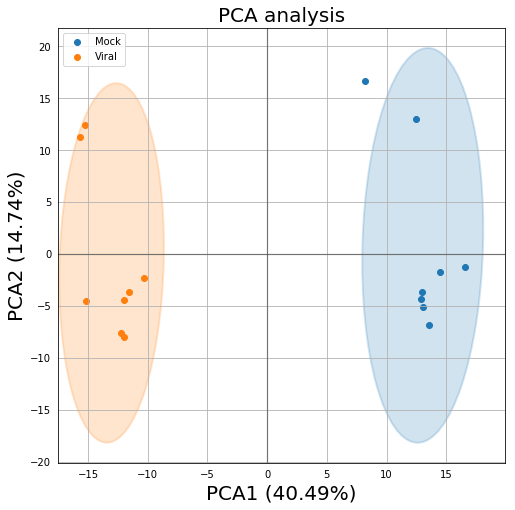

In [30]:
ax = pca.plot_row_coordinates(
    x1,
    ax=None,
    figsize=(8, 8),
    x_component=0,
    y_component=1,
    labels=None,
    color_labels=y1,
    ellipse_outline=True,
    ellipse_fill=True,
    show_points=True
)

inertia = pca.explained_inertia_
x_label = 'PCA{} ({:.2f}%)'.format(1, 100 * inertia[0])
y_label = 'PCA{} ({:.2f}%)'.format(2, 100 * inertia[1])
ax.set_title('PCA analysis', fontsize=20)
ax.set_xlabel(x_label, fontsize=20)
ax.set_ylabel(y_label, fontsize=20)

### Calculating Differential Expression

In [1]:
library(cmapR)
library(limma)
library(data.table)
pooltotal_gct_intensity  <- parse.gctx("labeled_LCMS_pooltotals.gct")
pooltotal_mode_gct_mat  <- as.data.frame(pooltotal_gct_intensity@mat)
pooltotal_mode_gct_rdesc  <- pooltotal_gct_intensity@rdesc
pooltotal_mode_gct_cdesc  <- pooltotal_gct_intensity@cdesc
condition <- pooltotal_mode_gct_cdesc$Cohort
design <- model.matrix(~ condition + 0)
colnames(design) <- c("Mock", "Viral")
contrast.matrix <- makeContrasts(Mock - Viral, levels = design)
pooltotal_matrix = as.matrix(log2(pooltotal_mode_gct_mat))
fit <- lmFit(pooltotal_matrix, design)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)
tt <- topTable(fit, coef = "Mock - Viral", number = nrow(pooltotal_matrix))
total <- merge(pooltotal_mode_gct_rdesc, tt, by=0, all=TRUE)
print (head(total))
write.csv(total, "Labeled_LCMS_Mock_Viral_limma_results.csv", row.names=FALSE)

parsing as GCT v1.3
labeled_LCMS_pooltotals.gct 430 rows, 16 cols, 4 row descriptors, 1 col descriptors


                      Row.names                                    compound
1    1_C01137_354.147_7.426_neg                    S-Adenosylmethioninamine
2  10_C00255_375.131_12.676_neg                                  Riboflavin
3  100_C00096_604.071_13.37_neg                                 GDP-mannose
4 101_C00004_664.118_14.168_neg                                        NADH
5  102_C00003_663.107_9.227_neg                                        NAD+
6 103_C01284_578.888_13.627_neg 1D-myo-Inositol 1,3,4,5,6-pentakisphosphate
  compoundId   medMz  medRt                            id      logFC  AveExpr
1     C01137 354.147  7.426    1_C01137_354.147_7.426_neg  0.7689305     -Inf
2     C00255 375.131 12.676  10_C00255_375.131_12.676_neg  1.0337560 14.44967
3     C00096 604.071 13.370  100_C00096_604.071_13.37_neg  1.1696318 23.41049
4     C00004 664.118 14.168 101_C00004_664.118_14.168_neg  0.1068775 18.97281
5     C00003 663.107  9.227  102_C00003_663.107_9.227_neg -0.6131244     -Inf


### Creating CombiT Input

In [31]:
limma_results_df = pd.read_csv("Labeled_LCMS_Mock_Viral_limma_results.csv")
combit_input_df = filter_unique_cmpd_combiT(limma_results_df)
combit_input_df.head()

/home/rstudio/.local/lib/python3.5/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



ID     logFC       P.Value
uniqueId                                                     
1_C01137_354.147_7.426_neg     C01137  0.768930  3.840176e-05
10_C00255_375.131_12.676_neg   C00255  1.033756  8.754404e-03
100_C00096_604.071_13.37_neg   C00096  1.169632  1.515686e-10
101_C00004_664.118_14.168_neg  C00004  0.106878  7.577518e-01
102_C00003_663.107_9.227_neg   C00003 -0.613124  7.861669e-01

In [32]:
combit_input_df.to_csv('Labeled_LCMS_Mock_Viral_combit_input.csv', index=False)

### MSEA Analysis

In [38]:
# Filter compounds whose pval is less than 0.05
compoundId_sign_list = combit_input_df[combit_input_df['P.Value'] <= 0.05]['ID'].unique().tolist()
#print (compoundId_sign_list)
with open('Labeled_LCMS_Mock_Viral_MSEA_ORA_input.txt', 'w') as f:
    for compoundId in compoundId_sign_list:
        f.write("%s\n" % compoundId)

# Get list of unique Id's
unique_id_list = combit_input_df.index.values.tolist()
print (len(unique_id_list))

# filter unique ids
filtered_raw_intensity_df = pooltotal_df[pooltotal_df['uniqueId'].isin(unique_id_list)]

# Samples in rows
id_cols = ['uniqueId', 'compound', 'medMz', 'medRt']
data_cols = filtered_raw_intensity_df.columns
drop_cols = set(id_cols) & set(data_cols)
id_to_samples_df = filtered_raw_intensity_df.drop(drop_cols, axis=1)
id_to_samples_df = id_to_samples_df.set_index('compoundId').T.astype(float)
id_to_samples_df = id_to_samples_df.reset_index().rename(columns = {'index':'SampleName'})
#id_to_samples_df.head(5)

# Create metaboanalyst for "Mutant_proto" to "WT_proto" comparison
cohorts = ['Mock', 'Viral']
samples_list = id_to_samples_df.columns.tolist()[1:]
columns_order = ['SampleName', 'Cohort'] + samples_list
id_to_samples_cohorts_df =id_to_samples_df.merge(metadata_df, on="SampleName", how = 'inner')
id_to_samples_cohorts_df = id_to_samples_cohorts_df[columns_order]
binary_cohorts_id_samples_df = id_to_samples_cohorts_df[id_to_samples_cohorts_df['Cohort'].isin(cohorts)]
binary_cohorts_id_samples_df = binary_cohorts_id_samples_df.sort_values(['Cohort'])
binary_cohorts_id_samples_df.to_csv('Labeled_LCMS_Mock_Viral_MSEA_QEA_input.csv',index=False)

257
